In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

import datetime

%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
maxr = s.galrad
maxr = 0.01 #Mpc
iall, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [??]')

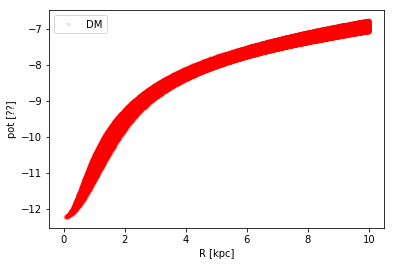

In [5]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')

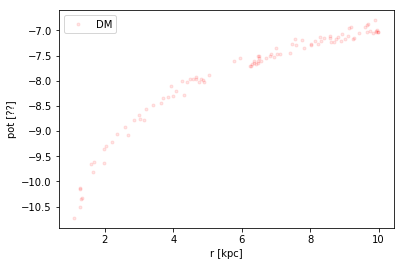

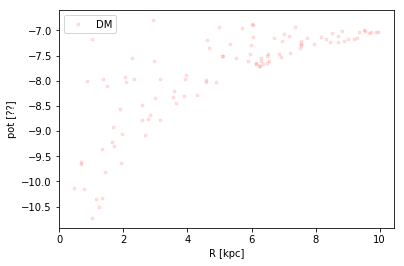

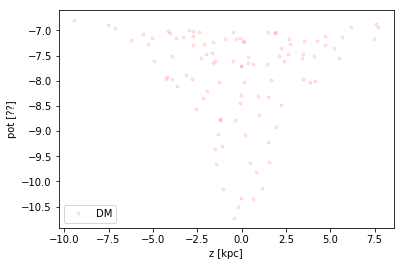

In [7]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)),101))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]

plt.plot(rand_r_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel('pot [??]')
plt.show()
plt.plot(rand_R_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')
plt.show()
plt.plot(rand_z_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('z [kpc]')
plt.ylabel('pot [??]')
plt.show()


In [11]:
### finde nen Weg um das ganze von klein r abhängig zu machen 
### finde sinnvolle Standartwerte für Initialisierungs Parameter
### eventuell nur dens ODER pot ausgeben, hängt von Fit funktion ab 
### ravel works in the way I want?


#def galpy_fitting(r, R, z, r0, v0, a_mp = 0.5, b_mp = 0.0375, n_mp = 0.6, a_nfw = 4.5, n_nfw = 0.35, \
#                  a_he = 0.6 / 8., n_he = 0.05, hr_de = 0.3333333333333333, hz_de = 0.0625, \
#                  dens_fit = True, pot_fit = False):
 

def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r = None, R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    #n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    #hep = HEpot(a = a_he, normalize = n_he)
    pot = [mp, nfwp]#, hep]         
    pot_mod = np.zeros((len(z), len(R)))
    for ii, zii in enumerate(z):
        for jj, Rjj in enumerate(R):
            pot_mod[ii, jj] = evaluatePotentials(pot, Rjj, zii)
    return pot_mod

# FITTING

def RMS(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, #x[6] #a_he
    ydat = pot
    yfit = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r, R, z, r0) * v0**2
    RMS = np.sqrt(1./N*np.sum((ydat - yfit)**2))
    chi = np.sum((yfit - ydat)**2/(ydat))
    #print(datetime.datetime.now().time())
    #print(RMS)
    #print(chi)
    #print(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0)
    print(RMS)
    return RMS

def chi(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, #x[6] #a_he
    ydat = pot
    yfit = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0, r, R, z, r0) * v0**2
    RMS = np.sqrt(1./N*np.sum((ydat - yfit)**2))
    chi = np.abs(np.sum((yfit - ydat)**2/(ydat)))
    #print(datetime.datetime.now().time())
    #print(RMS)
    #print(chi)
    #print(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0)
    return chi

a_mp = 0.5 
b_mp = 0.1#0.0375 
n_mp = 0.6  
a_nfw = 3 #4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 

v0 = 200.

pot = rand_pot_dm
r, R, z = rand_r_dm, rand_R_dm, rand_z_dm
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , v0) #n_he

bounds = ((0., None), (0., None), (0., 0.999), (0., None), (0., 0.999), (0., None)) #n_he
#r, R, z, rho = R, Rbin, z, rho
#rho, R, z, vol = fitting_dens(s)

r0 = 8.
N = len(r)
# v0 muss mitgefittet werden
print(x0)

cons = ({'type': 'eq', 'fun': lambda x:  1. - (x[2] + x[4] )})

res_rms = opt.minimize(RMS, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds, constraints = cons)
res_chi = opt.minimize(chi, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds, constraints = cons)

(0.5, 0.1, 0.6, 3, 0.35, 200.0)
806306.503364
806306.503364
806306.504802
806306.505019
806306.505554
806306.506914
806306.533941
806306.503484


In [12]:
res_rms


     fun: 806306.5033640411
     jac: array([   96506.0625   ,   111087.5625   ,   146994.1640625,
         238232.59375  ,  2051967.5703125,     8063.8515625])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([  5.00000000e-01,   1.00000000e-01,   6.00000000e-01,
         3.00000000e+00,   3.50000000e-01,   2.00000000e+02])

In [10]:
res_chi

     fun: 8110536415341.445
     jac: array([  1.91010210e+12,   2.17688519e+12,   2.86612141e+12,
         4.85189131e+12,   4.14371190e+13,   1.62226635e+11])
 message: 'Inequality constraints incompatible'
    nfev: 8
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([  5.00000000e-01,   1.00000000e-01,   6.00000000e-01,
         3.00000000e+00,   3.50000000e-01,   2.00000000e+02])

In [ ]:
a_mp_rms, b_mp_rms, n_mp_rms = res_rms.x[0], res_rms.x[1], res_rms.x[2]
a_nfw_rms , n_nfw_rms = res_rms.x[3]  , res_rms.x[4]
#a_he, n_he = res.x[5],  res.x[6]
a_mp_chi, b_mp_chi, n_mp_chi = res_chi.x[0], res_chi.x[1], res_chi.x[2]
a_nfw_chi , n_nfw_chi = res_chi.x[3]  , res_chi.x[4]

In [ ]:
mp_rms = MNpot(a = a_mp_rms, b = b_mp_rms, normalize = n_mp_rms, ro = r0, vo = v0)
nfwp_rms = NFWpot(a = a_nfw_rms, normalize = n_nfw_rms, ro = r0, vo = v0)
#hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
    
pot_rms = [mp_rms,nfwp_rms]#,hep]

mp_chi = MNpot(a = a_mp_chi, b = b_mp_chi, normalize = n_mp_chi, ro = r0, vo = v0)
nfwp_chi = NFWpot(a = a_nfw_chi, normalize = n_nfw_chi, ro = r0, vo = v0)
    
pot_chi = [mp_chi,nfwp_chi]#,hep]

In [ ]:
plotDensities(pot_rms,nrs=101,nzs=101, log = True)

In [ ]:
plotDensities(pot_chi,nrs=101,nzs=101, log = True)